In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%%capture
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from os import listdir
from PIL import ImageOps, Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as splitTrainingData
from sklearn.metrics import accuracy_score

In [0]:
# Fonction d'entrainement
def training(model, train_dataloader, valid_dataloader=None, epoch=5, learning_rate=0.1, use_gpu=False):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  train_accu = []
  train_losses = []
  
  if valid_dataloader:
    val_accu = []
    val_loss = []
    
  for i in range(epoch):
    model.train()
    
    print('Starting epoch number {} on {} ...'.format(i+1, epoch))
    
    true = []
    pred = []
    train_loss = []
    len_train = len(train_dataloader)
    for ind, batch in enumerate(train_dataloader):
      print('\rBatch : {}/{}'.format(ind+1, len_train), end='')
      inputs, targets = batch
      
      # Aller le GPU, fais ton taff
      if use_gpu:
        inputs = inputs.cuda()
        targets = targets.cuda()
      
      optimizer.zero_grad()
        
      outputs = model(inputs)
      
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      
      predictions = outputs.max(dim=1)[1]
      
      train_loss.append(loss.item())
      true.extend(targets.data.cpu().numpy().tolist())
      pred.extend(predictions.data.cpu().numpy().tolist())
    
    accu_score = accuracy_score(true, pred) * 100
    loss_score = sum(train_loss) / len(train_loss)
    
    print('\nTrain score : Accuracy = {:.2f} - Loss = {:.2f}'.format(accu_score, loss_score), end='')
    
    
    train_accu.append(accuracy_score(true, pred) * 100)
    train_losses.append(loss_score)
      
    if valid_dataloader:
      vaccu, vloss = validating(model, valid_dataloader, use_gpu)
      print(' | Validation score : Accuracy = {:.2f} - Loss = {:.2f}'.format(vaccu, vloss))
      val_accu.append(vaccu)
      val_loss.append(vloss)
    else:
      print()
  
  if valid_dataloader:
    return train_accu, train_losses, val_accu, val_loss
  else:
    return train_accu, train_loss
  
  return None, None
  

# Fonction de validation
def validating(model, dataloader, use_gpu=False):
  true =[]
  pred = []
  val_loss = []

  criterion = nn.NLLLoss()
  model.eval()

  for batch in dataloader:

    inputs, targets = batch

    # On envoit les données au GPU pour le traitement
    if use_gpu:
      inputs = inputs.cuda()
      targets = targets.cuda()
    
    outputs = model(inputs)

    predictions = outputs.max(dim=1)[1]

    val_loss.append(criterion(outputs, targets).item())
    true.extend(targets.data.cpu().numpy().tolist())
    pred.extend(predictions.data.cpu().numpy().tolist())
  
  accu_score = accuracy_score(true, pred) * 100
  loss_score = sum(val_loss) / len(val_loss)
  return accu_score, loss_score


# Fonction de prédiction
#def predict(model, sentence, vocab, max_len):
#  tokens = word_tokenize(sentence)
#  X_test_len = len(tokens)
#  X_test = prepareData(tokens, vocab, max_len)
#  X_test = torch.LongTensor(X_test).cuda()
#  X_test_len = torch.FloatTensor(X_test_len).cuda()
#  output = model(X_test, X_test_len)
#  prediction = output.max(dim=1)[1]
#  print(prediction)

In [0]:
%%script false
# Cellule pour éviter les doublons dans les positifs et négatifs.
# Lancer la cellule 2 fois pour que le calcul se fasse

files_pos = [f for f in listdir("/content/gdrive/My Drive/datas/pixabay/dogs/1")]
files_neg = [f for f in listdir("/content/gdrive/My Drive/datas/pixabay/dogs/0")]

cnt = 0
for f in files_pos:
  if f in files_neg:
    cnt += 1
    
print(cnt)

Dans ce cadre précis il faut ajouter du padding à chaque image. Pour se faire, nous devons rechercher la largeur max et la longueur max.

In [0]:
class AddPadding:
  def __init__(self, maxHeight, maxWidth):
    self.maxHeight = maxHeight
    self.maxWidth = maxWidth

  def __call__(self, img):
    # Utilisation du code https://discuss.pytorch.org/t/add-padding-to-images/24309/3
    delta_width = self.maxWidth - img.size[0]
    delta_height = self.maxHeight - img.size[1]
    pad_width = delta_width //2
    pad_height = delta_height //2
    padding = (pad_width,pad_height,delta_width-pad_width,delta_height-pad_height)
    return ImageOps.expand(img, padding)

def create_dataloader(dataset, train_sampler, valid_sampler, b_size):
    train_loader = DataLoader(
        dataset,
        batch_size = b_size,
        num_workers = 0,
        sampler = train_sampler
    )
    valid_loader = DataLoader(
        dataset,
        batch_size = 1,
        num_workers = 0,
        sampler = valid_sampler
    )
    return train_loader, valid_loader

In [0]:
# On charge les dataloaders (en supprimant les images précédentes pour libérer l'espace)
img_path = "/content/gdrive/My Drive/datas/pixabay/dogs/"
maxH = 340
maxW = 1162
all_transforms = transforms.Compose(
    [
     AddPadding(maxH, maxW),
     transforms.ToTensor()
    ]
)
dataset = torchvision.datasets.ImageFolder(
    root=img_path,
    transform=all_transforms
)

# Split en test et validation : https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
validation_split = 0.1
random_seed = 15
batch_size = 64
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Dataloader
train_loader, valid_loader = create_dataloader(dataset, train_sampler, valid_sampler, batch_size)

model = torchvision.models.resnet18(pretrained=True)

# La classification se fait sur 2 classes uniquement
model.fc = nn.Linear(512, 2)
#print(model)

In [0]:
train_accu, train_loss, val_accu, val_loss = training(model.cuda(), train_loader, valid_loader, epoch=10, use_gpu=True)

Starting epoch number 1 on 10 ...
Batch : 291/291
Train score : Accuracy = 69.27 - Loss = 0.87 | Validation score : Accuracy = 72.25 - Loss = -0.40
Starting epoch number 2 on 10 ...
Batch : 291/291
Train score : Accuracy = 69.86 - Loss = 0.67 | Validation score : Accuracy = 72.06 - Loss = -0.10
Starting epoch number 3 on 10 ...
Batch : 291/291
Train score : Accuracy = 71.42 - Loss = 0.64 | Validation score : Accuracy = 72.25 - Loss = -0.19
Starting epoch number 4 on 10 ...
Batch : 291/291
Train score : Accuracy = 71.82 - Loss = 0.63 | Validation score : Accuracy = 72.25 - Loss = -0.51
Starting epoch number 5 on 10 ...
Batch : 291/291
Train score : Accuracy = 72.43 - Loss = 0.61 | Validation score : Accuracy = 71.67 - Loss = -0.15
Starting epoch number 6 on 10 ...
Batch : 291/291
Train score : Accuracy = 72.38 - Loss = 0.60 | Validation score : Accuracy = 72.25 - Loss = -0.44
Starting epoch number 7 on 10 ...
Batch : 291/291
Train score : Accuracy = 72.41 - Loss = 0.59 | Validation scor

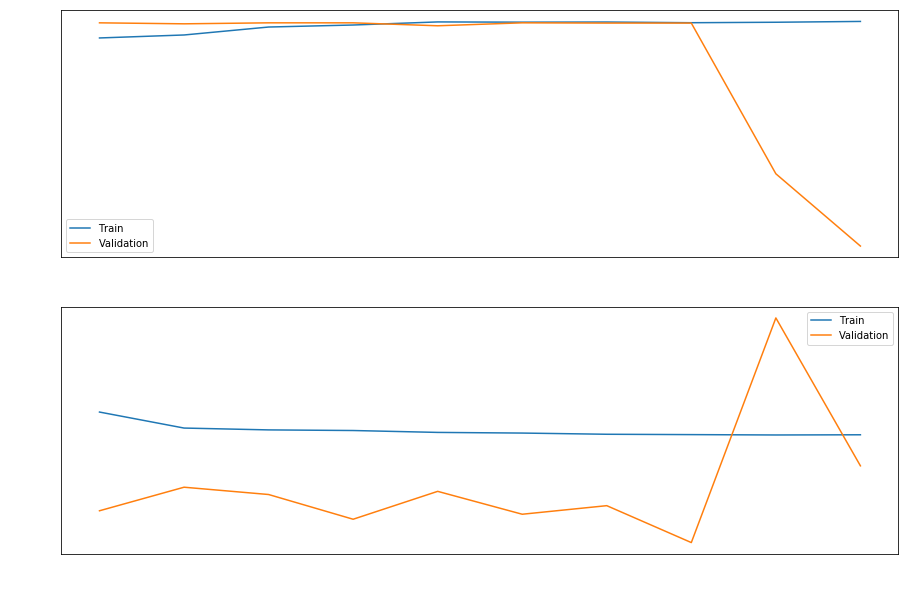

In [0]:
font_config = {
    'family': 'serif',
    'weight': 'normal',
    'color': 'white',
    'size': 20
}

axe_font = {
    'family': 'serif',
    'weight': 'normal',
    'color': 'white',
    'size': 10
}

epoch = len(train_accu)
epochs = [x for x in range(1, epoch + 1)]

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].set_xlabel('Epochs', fontdict=font_config)
axes[0].set_ylabel('Accuracy', fontdict=font_config)
axes[0].tick_params(axis='both', labelcolor='white', color='white')
axes[0].plot(epochs, train_accu, label='Train')
axes[0].plot(epochs, val_accu, label='Validation')
axes[0].legend()

axes[1].set_xlabel('Epochs', fontdict=font_config)
axes[1].set_ylabel('Loss', fontdict=font_config)
axes[1].tick_params(axis='both', labelcolor='white', color='white')
axes[1].plot(epochs, train_loss, label='Train')
axes[1].plot(epochs, val_loss, label='Validation')
axes[1].legend()

plt.show()